In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as plt
from rdflib import Graph, URIRef
from rdflib.namespace import RDF
from sklearn.manifold import TSNE

In [2]:
base_dir = 'benchmarks/DASHB'

with open(os.path.join(base_dir, 'results', 'TransE.json'), 'r') as embedding_f:
    embeddings = json.load(embedding_f)

entity_embeddings = np.array(embeddings['ent_embeddings.weight'])
relation_embeddings = np.array(embeddings['rel_embeddings.weight'])

print(f'Entity embeddings: {entity_embeddings.shape}')
print(f'Relation embeddings: {relation_embeddings.shape}')

Entity embeddings: (6129, 50)
Relation embeddings: (17, 50)


### Context

In [3]:
graph = Graph()
graph.parse(os.path.join(base_dir, 'graph.ttl'))

<Graph identifier=N27ce717bcdbd496aa426942ae3674c05 (<class 'rdflib.graph.Graph'>)>

In [4]:
entities = pd.read_csv(os.path.join(base_dir, 'entity2id.txt'), skiprows=1, names=['id'], usecols=[0], header=None, sep='\t')

entity_types = {}
for result in graph.subject_objects(predicate=RDF.type):
    entity = str(result[0])
    type_ = str(result[1])
    
    if entity not in entity_types.keys():
        entity_types[entity] = [type_]
    else:
        entity_types[entity].append(type_)

entities.loc[:, ('type')] = [', '.join(entity_types[row['id']]) if row['id'] in entity_types.keys() else 'None' for idx, row in entities.iterrows()]

In [5]:
relations = pd.read_csv(os.path.join(base_dir, 'relation2id.txt'), skiprows=1, names=['id'], usecols=[0], header=None, sep='\t')

### t-SNE
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [6]:
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
Y = tsne.fit_transform(entity_embeddings)

entity_tsne = pd.DataFrame({'x': Y[:, 0], 'y': Y[:, 1]})

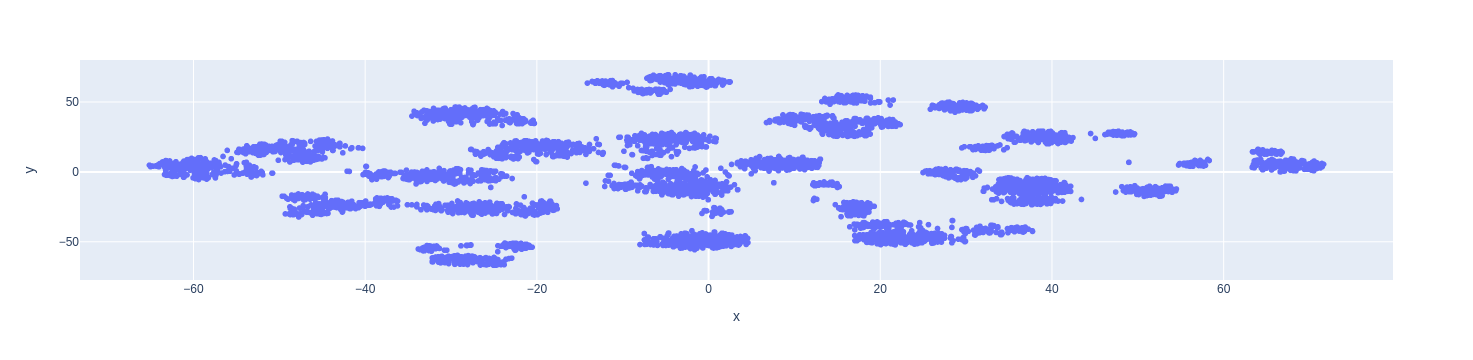

In [7]:
fig = px.scatter(entity_tsne, x='x', y='y')
fig.show()

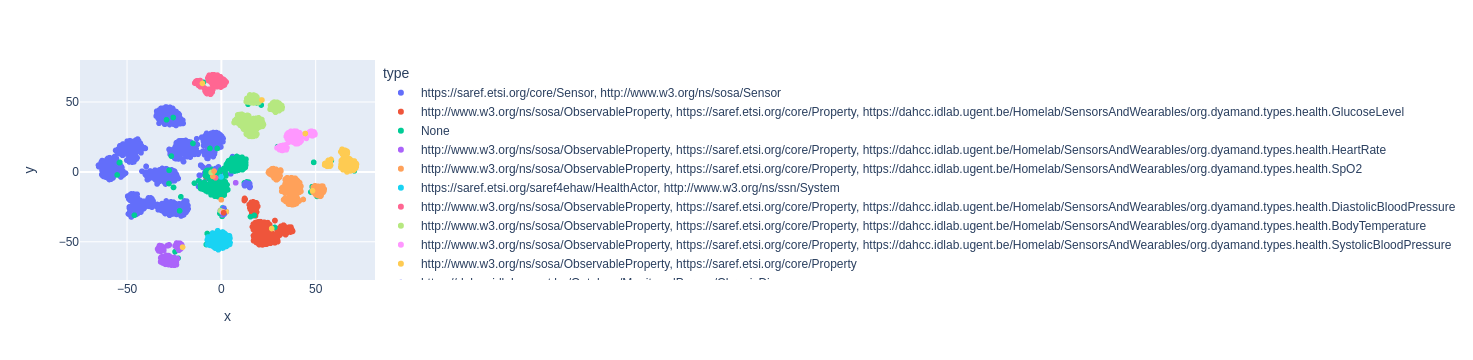

In [8]:
entity_tsne = entity_tsne.join(entities)

fig = px.scatter(entity_tsne, x='x', y='y', color='type', hover_data=['id'])
fig.show()

In [9]:
patient_class = 'http://example.com/tx/patients/'
patients = entities[entities['id'].str.contains(patient_class)]

patients_tsne = entity_tsne.iloc[patients.index].copy()

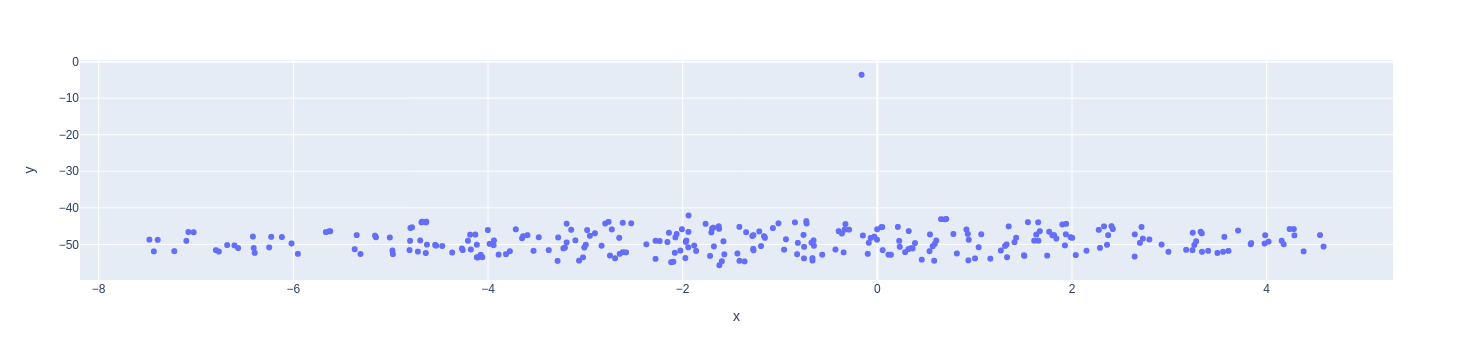

In [10]:
fig = px.scatter(patients_tsne, x='x', y='y', hover_data=['id'])
fig.show()

#### Diseases

In [11]:
patient_diseases = {}
for idx, row in patients_tsne.iterrows():
    pid = row['id']
    
    patient_diseases[pid] = []

    for disease in graph.objects(subject=URIRef(pid), predicate=URIRef('https://saref.etsi.org/saref4ehaw/hasChronicDisease')):
        patient_diseases[pid].append(str(disease))

diseases = [patient_diseases[row['id']] if row['id'] in patient_diseases.keys() else 'None' for idx, row in patients_tsne.iterrows()]
patients_tsne.loc[:, ('diseases')] = [', '.join(patient_diseases[row['id']]) if patient_diseases[row['id']] else 'None' for idx, row in patients_tsne.iterrows()]
patients_tsne.loc[:, ('hasDiabetes')] = [True if 'http://example.com/tx/diseases/Diabetes' in patient_diseases[row['id']] else False for idx, row in patients_tsne.iterrows()]

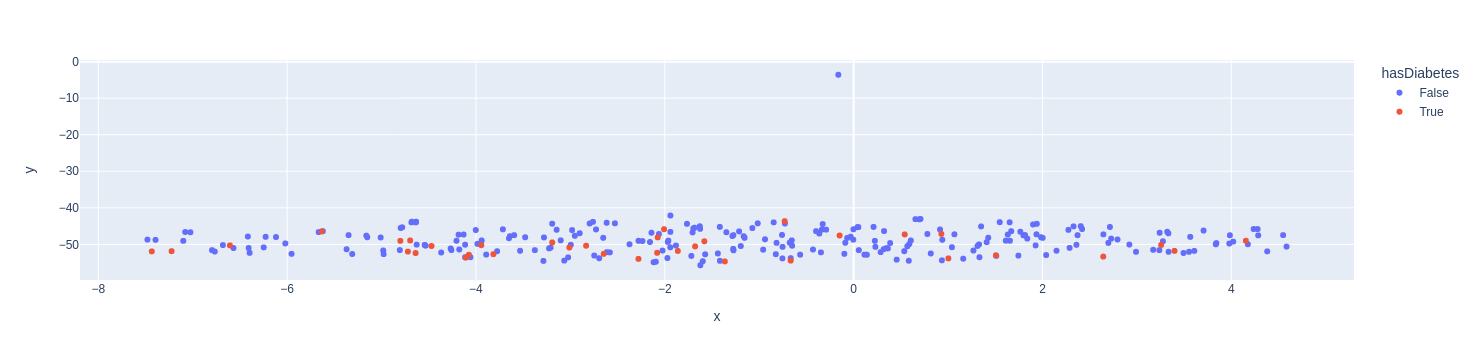

In [12]:
fig = px.scatter(patients_tsne, x='x', y='y', color='hasDiabetes', hover_data=['id', 'diseases'])
fig.show()

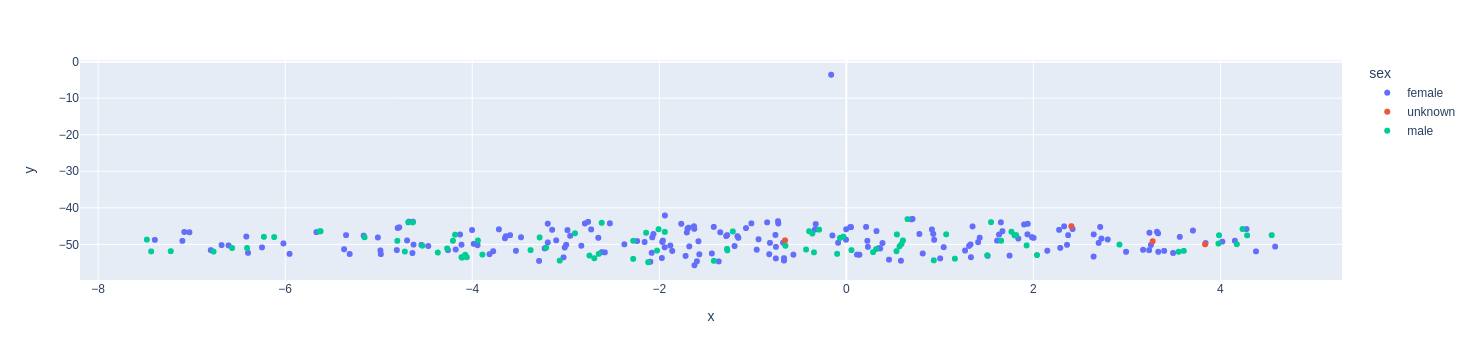

In [13]:
patients_tsne.loc[:, ('sex')] = [list(graph.objects(subject=URIRef(row['id']), predicate=URIRef('https://dahcc.idlab.ugent.be/Ontology/MonitoredPerson/Sex')))[0] for idx, row in patients_tsne.iterrows()]

fig = px.scatter(patients_tsne, x='x', y='y', color='sex', hover_data=['id', 'diseases'])
fig.show()

### Summation of embeddings (1st order)

In [14]:
patient_relations = {}
for idx, row in patients_tsne.iterrows():
    pid = row['id']
    
    patient_relations[pid] = []

    for entity in graph.objects(subject=URIRef(pid), predicate=None):
        patient_relations[pid].append(str(entity))

In [15]:
entity_embeddings_sum = entity_embeddings.copy()

for pid, relations_ in patient_relations.items():
    patient_idx = entities[entities.loc[:, ('id')] == pid].index
    patient_embedding = entity_embeddings[patient_idx].reshape((entity_embeddings.shape[1],))
    
    for entity in relations_:
        entity_idx = entities[entities.loc[:, ('id')] == entity].index
        entity_embedding = entity_embeddings[entity_idx].reshape((entity_embeddings.shape[1],))
        
        patient_embedding += entity_embedding
        
    entity_embeddings_sum[patient_idx] = patient_embedding

In [16]:
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
Y = tsne.fit_transform(entity_embeddings_sum)

df = pd.DataFrame({'x': Y[:, 0], 'y': Y[:, 1]})
df = df.join(entities)

patients_df = df.iloc[patients.index].copy()

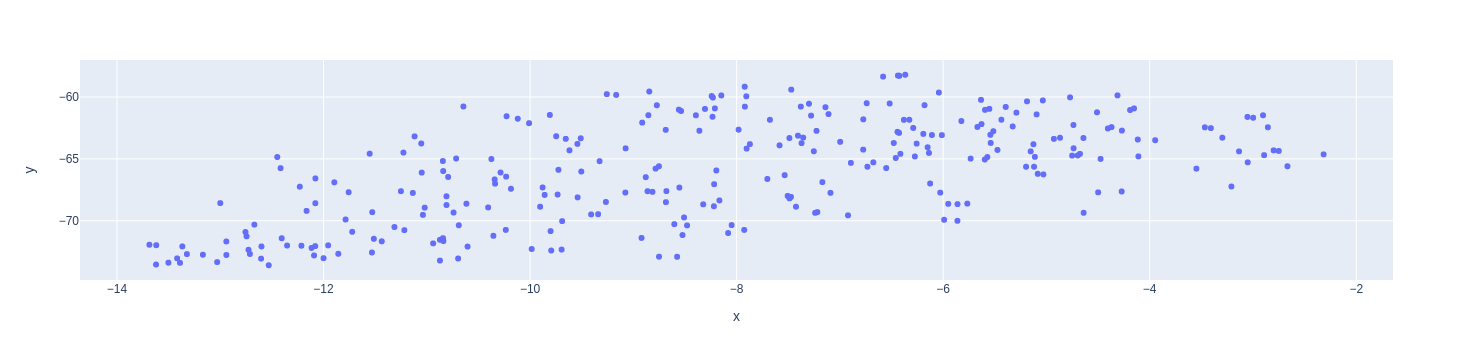

In [17]:
fig = px.scatter(patients_df, x='x', y='y', hover_data=['id'])
fig.show()

In [18]:
patients_df.loc[:, ('diseases')] = [', '.join(patient_diseases[row['id']]) if patient_diseases[row['id']] else 'None' for idx, row in patients_df.iterrows()]
patients_df.loc[:, ('hasDiseases')] = [True if patient_diseases[row['id']] else False for idx, row in patients_df.iterrows()]

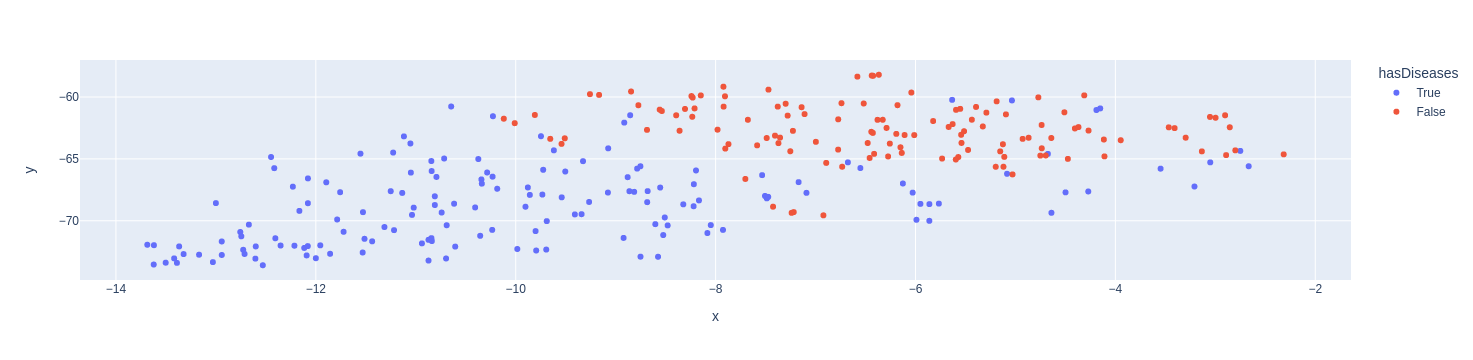

In [19]:
fig = px.scatter(patients_df, x='x', y='y', color='hasDiseases', hover_data=['id', 'diseases'])
fig.show()

### Multipliction of embeddings (1st order)

In [20]:
entity_embeddings_mul = entity_embeddings.copy()

for pid, relations_ in patient_relations.items():
    patient_idx = entities[entities.loc[:, ('id')] == pid].index
    patient_embedding_mul = entity_embeddings[patient_idx].reshape((entity_embeddings.shape[1],))
    
    for entity in relations_:
        entity_idx = entities[entities.loc[:, ('id')] == entity].index
        entity_embedding = entity_embeddings[entity_idx].reshape((entity_embeddings.shape[1],))
        
        patient_embedding_mul = np.multiply(patient_embedding_mul, entity_embedding)
        
    entity_embeddings_mul[patient_idx] = patient_embedding_mul

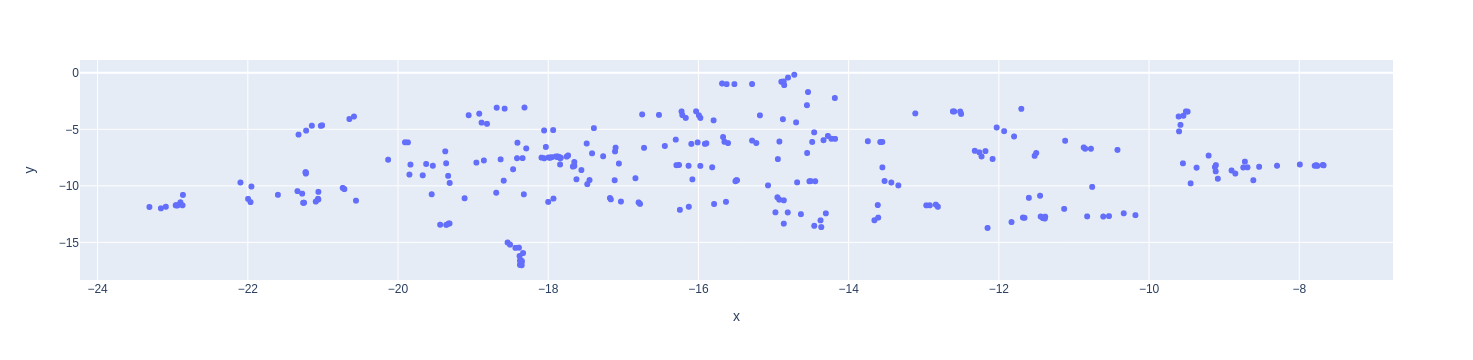

In [21]:
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
Y = tsne.fit_transform(entity_embeddings_mul)

df = pd.DataFrame({'x': Y[:, 0], 'y': Y[:, 1]})
df = df.join(entities)

patients_df = df.iloc[patients.index].copy()

fig = px.scatter(patients_df, x='x', y='y', hover_data=['id'])
fig.show()

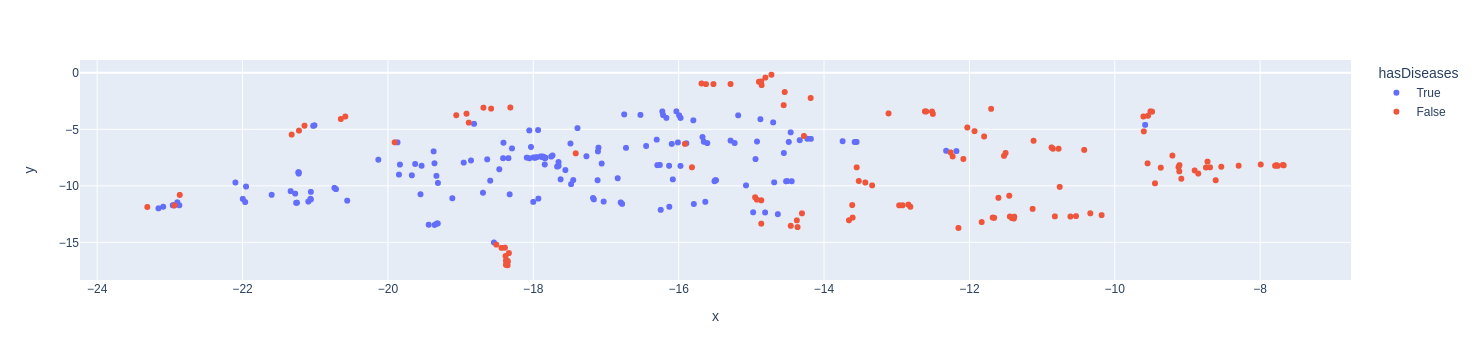

In [22]:
patients_df.loc[:, ('diseases')] = [', '.join(patient_diseases[row['id']]) if patient_diseases[row['id']] else 'None' for idx, row in patients_df.iterrows()]
patients_df.loc[:, ('hasDiseases')] = [True if patient_diseases[row['id']] else False for idx, row in patients_df.iterrows()]

fig = px.scatter(patients_df, x='x', y='y', color='hasDiseases', hover_data=['id', 'diseases'])
fig.show()

### Weighted summation (1st order)

In [23]:
patient_relations = {}
for idx, row in patients_df.iterrows():
    pid = row['id']
    
    patient_relations[pid] = []

    for s, p, o in graph.triples((URIRef(pid), None, None)):
        patient_relations[pid].append((str(p), str(o)))

In [24]:
weighted_entity_embeddings_sum = entity_embeddings.copy()

for pid, relations_ in patient_relations.items():
    patient_idx = entities[entities.loc[:, ('id')] == pid].index
    patient_embedding = entity_embeddings[patient_idx].reshape((entity_embeddings.shape[1],))
    
    for relation, entity in relations_:
        entity_idx = entities[entities.loc[:, ('id')] == entity].index
        entity_embedding = entity_embeddings[entity_idx].reshape((entity_embeddings.shape[1],))
        
        relation_idx = relations[relations.loc[:, ('id')] == relation].index
        relation_embedding = entity_embeddings[relation_idx].reshape((relation_embeddings.shape[1],))
        
        patient_embedding += np.multiply(relation_embedding, entity_embedding)
        
    weighted_entity_embeddings_sum[patient_idx] = patient_embedding

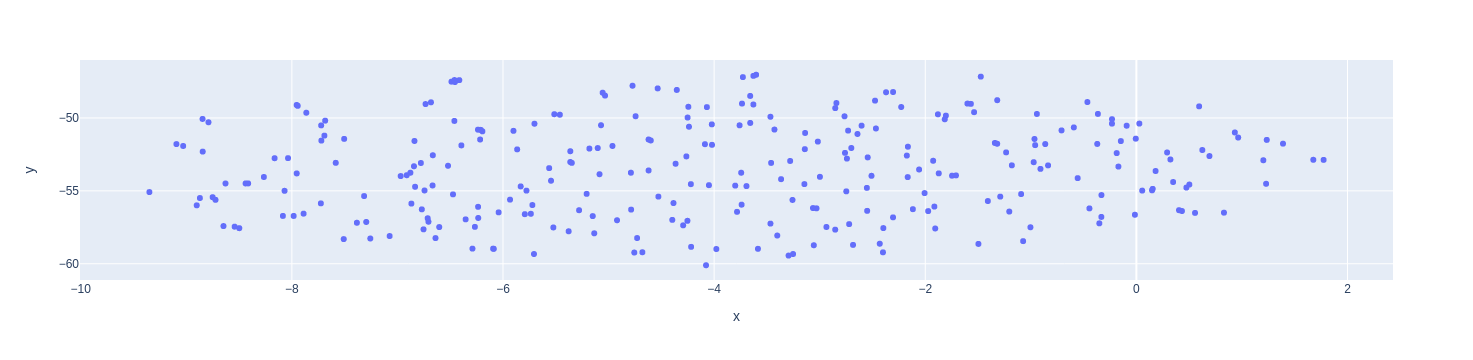

In [25]:
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init='random')
Y = tsne.fit_transform(weighted_entity_embeddings_sum)

df = pd.DataFrame({'x': Y[:, 0], 'y': Y[:, 1]})
df = df.join(entities)

patients_df = df.iloc[patients.index].copy()

fig = px.scatter(patients_df, x='x', y='y', hover_data=['id'])
fig.show()

### Distances

In [26]:
distances = {}

for idx, row in patients.iterrows():
    pid = row['id']
    distances[pid] = {}
    
    embedding = entity_embeddings[idx]
    
    for idx_, row_ in patients.iterrows():
        pid_ = row_['id']
        embedding_ = entity_embeddings[idx_]
        
        if pid == pid_:
            distances[pid][pid_] = 0
        elif pid_ in distances.keys():
            distances[pid][pid_] = distances[pid_][pid]
        else:
            distances[pid][pid_] = np.linalg.norm(embedding - embedding_)

In [27]:
# print(distances['http://example.com/tx/patients/zplus_6'])
print(sorted(distances['http://example.com/tx/patients/zplus_6'].items(), key=lambda x: x[1])[1:6])

[('http://example.com/tx/patients/zplus_24', 0.3956203038383293), ('http://example.com/tx/patients/zplus_88', 0.42695832100638315), ('http://example.com/tx/patients/zplus_213', 0.4284912588260997), ('http://example.com/tx/patients/zplus_201', 0.43329690313627034), ('http://example.com/tx/patients/zplus_123', 0.4367822548267993)]


In [28]:
distances_ = [list(distances[pid].values()) for pid in distances.keys()]
patient_ids = list(distances.keys())

# fig = ff.create_annotated_heatmap(distances_, x=patient_ids, y=patient_ids)
# fig.show()